### This notebook generates 2-dimensional PCA plots for synthetic data generated by six generative models using with and without HFGF

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from scipy.stats import norm
from sklearn.metrics.pairwise import pairwise_kernels
from matplotlib.ticker import MultipleLocator, FormatStrFormatter



os.environ["OMP_NUM_THREADS"] = "1"
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False




'case1': 'Real_simulated_data/test_v0.csv'
    
     'case1': {
        'Synth_CTGAN_without_HFGF':  'Synthetic_data/ctgan/synthetic_ctgan_test_v0.csv',
        'Synth_CTGAN_with_HFGF':     'Synthetic_data/ctgan/synthetic_ctgan_test_v0_dependent_mapping.csv',
        'Synth_CTABGAN+_without_HFGF':'Synthetic_data/ctabgan+/synthetic_ctabgan+_test_v0.csv',
        'Synth_CTABGAN+_with_HFGF':  'Synthetic_data/ctabgan+/synthetic_ctabgan+_test_v0_dependent_mapping.csv',
        'Synth_TVAE_without_HFGF':'Synthetic_data/tvae/synthetic_tvae_test_v0.csv',
        'Synth_TVAE_with_HFGF':  'Synthetic_data/tvae/synthetic_tvae_test_v0_dependent_mapping.csv',
        'Synth_GReaT_without_HFGF':  'Synthetic_data/great/synthetic_great_test_v0.csv',
        'Synth_GReaT_with_HFGF':     'Synthetic_data/great/synthetic_great_test_v0_dependent_mapping.csv'
    }

### Here I generated for fourth case simulated data, if you want to generate for all 3 cases, just pass the file names in the dictionary like:


=== MMD in High-Dimensional Feature Space (case4) ===
Synth_CTGAN_without_HFGF                 -> MMD = 0.0144
Synth_CTGAN_with_HFGF                    -> MMD = 0.0077
Synth_CTABGAN+_without_HFGF              -> MMD = 0.0157
Synth_CTABGAN+_with_HFGF                 -> MMD = -0.0019
Synth_TVAE_without_HFGF                  -> MMD = 0.0093
Synth_TVAE_with_HFGF                     -> MMD = 0.0736
Synth_NextConvGen_without_HFGF           -> MMD = 0.0073
Synth_NextConvGen_with_HFGF              -> MMD = 0.0057
Synth_TabuLa_without_HFGF                -> MMD = 0.0073
Synth_TabuLa_with_HFGF                   -> MMD = -0.0020
Synth_GReaT_without_HFGF                 -> MMD = 0.0076
Synth_GReaT_with_HFGF                    -> MMD = 0.0004


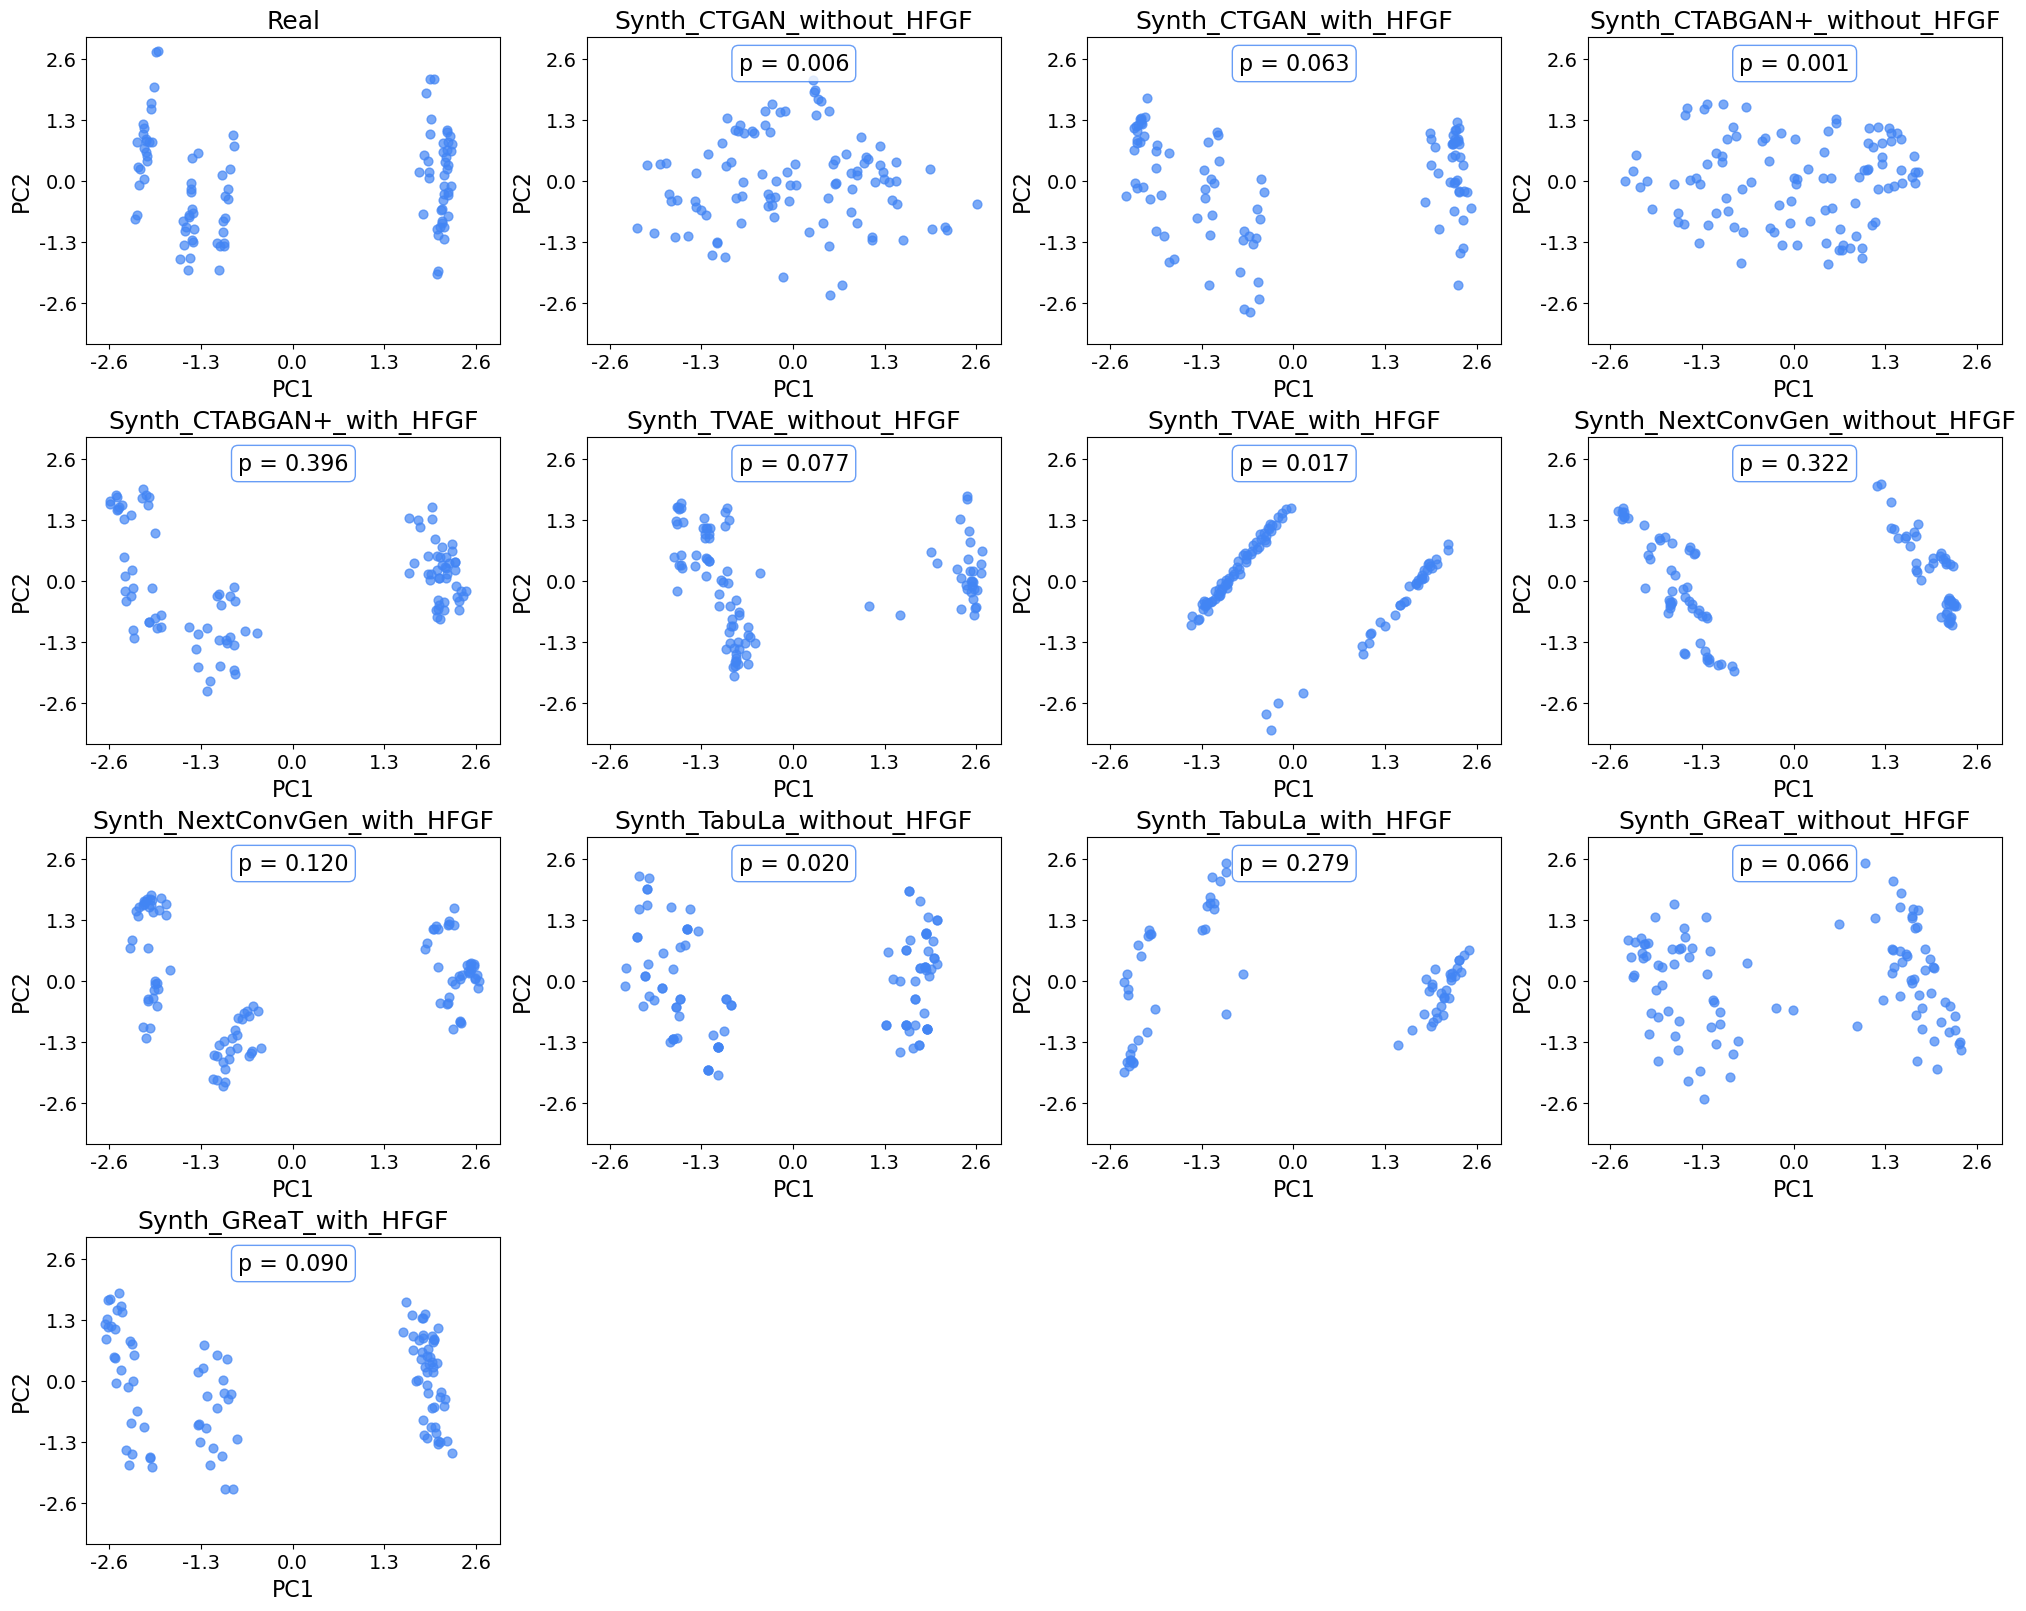

In [2]:
import matplotlib as mpl
mpl.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})
plt.rcParams['pdf.fonttype'] = 42  # Optional: Embed fonts properly for LaTeX


# Define paths
real_paths = {'case4': 'Real_simulated_data/test_check_v3_imbalance.csv'}
synth_paths_per_real = {
    'case4': {
        'Synth_CTGAN_without_HFGF':  'Synthetic_data/ctgan/synthetic_ctgan_test_check_v3_imbalance.csv',
        'Synth_CTGAN_with_HFGF':     'Synthetic_data/ctgan/synthetic_ctgan_test_check_v3_imbalance_dependent_mapping.csv',
        'Synth_CTABGAN+_without_HFGF':'Synthetic_data/ctabgan+/synthetic_ctabgan+_test_check_v3_imbalance.csv',
        'Synth_CTABGAN+_with_HFGF':  'Synthetic_data/ctabgan+/synthetic_ctabgan+_test_check_v3_imbalance_dependent_mapping.csv',
        'Synth_TVAE_without_HFGF':'Synthetic_data/tvae/synthetic_tvae_test_check_v3_imbalance.csv',
        'Synth_TVAE_with_HFGF':  'Synthetic_data/tvae/synthetic_tvae_test_check_v3_imbalance_dependent_mapping.csv',
        'Synth_NextConvGen_without_HFGF':'Synthetic_data/nextconvgen/synthetic_nextconvgen_test_check_v3_imbalance.csv',
        'Synth_NextConvGen_with_HFGF':  'Synthetic_data/nextconvgen/synthetic_nextconvgen_test_check_v3_dependent_mapping_imbalance.csv',
        'Synth_TabuLa_without_HFGF':'Synthetic_data/tabula/synthetic_tabula_test_check_v3_imbalance.csv',
        'Synth_TabuLa_with_HFGF':  'Synthetic_data/tabula/synthetic_tabula_test_check_v3_dependent_mapping_imbalance.csv',
        'Synth_GReaT_without_HFGF':  'Synthetic_data/great/synthetic_great_test_check_v3_imbalance.csv',
        'Synth_GReaT_with_HFGF':     'Synthetic_data/great/synthetic_great_test_check_v3_imbalance_dependent_mapping.csv'
    }
}

def peacock_test(sample1, sample2):
    n1, d1 = sample1.shape
    n2, d2 = sample2.shape
    if d1 != d2:
        raise ValueError("Samples must have the same dimensionality.")
    combined = np.vstack((sample1, sample2))
    n = combined.shape[0]
    mins = combined.min(axis=0)
    maxs = combined.max(axis=0)
    grid = np.linspace(mins, maxs, n, axis=0)
    ecdf1 = np.array([np.mean(np.all(sample1 <= pt, axis=1)) for pt in grid])
    ecdf2 = np.array([np.mean(np.all(sample2 <= pt, axis=1)) for pt in grid])
    D = np.max(np.abs(ecdf1 - ecdf2))
    z = D * np.sqrt((n1 * n2) / (n1 + n2))
    p = 2 * (1 - norm.cdf(z))
    return D, p

def compute_mmd_unbiased(X, Y, kernel='rbf', gamma=1.0):
    n = min(len(X), len(Y))
    X = X[np.random.choice(len(X), n, replace=False)]
    Y = Y[np.random.choice(len(Y), n, replace=False)]

    K_XX = pairwise_kernels(X, X, metric=kernel, gamma=gamma)
    K_YY = pairwise_kernels(Y, Y, metric=kernel, gamma=gamma)
    K_XY = pairwise_kernels(X, Y, metric=kernel, gamma=gamma)

    sum_K_XX = K_XX.sum() - np.trace(K_XX)
    sum_K_YY = K_YY.sum() - np.trace(K_YY)

    mmd2 = (sum_K_XX / (n * (n - 1))) + \
           (sum_K_YY / (n * (n - 1))) - \
           2 * K_XY.mean()

    return (mmd2)

# Storage for CSV output
mmd_csv_records = []

for real_name, real_path in real_paths.items():
    df_real = pd.read_csv(real_path)
    synth_dfs = {n: pd.read_csv(p) for n, p in synth_paths_per_real[real_name].items()}

    # Preprocessing
    num_cols = df_real.select_dtypes(include=[np.number]).columns
    cat_cols = df_real.select_dtypes(include=['object', 'category']).columns
    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='drop')
    Xr = pre.fit_transform(df_real)
    processed = {'Real': Xr}
    for n, df in synth_dfs.items():
        processed[n] = pre.transform(df)

    # Compute MMD in high-dimensional feature space with subsampling
    mmd_highdim = {}
    Xreal_hd = processed['Real']
    for name, Xs in processed.items():
        if name == 'Real': continue
        mmd_val = compute_mmd_unbiased(Xreal_hd, Xs)
        mmd_highdim[name] = mmd_val
        mmd_csv_records.append({
            'real_dataset': real_name,
            'synthetic_model': name,
            'high_dimensional_MMD': mmd_val
        })

    # Print high-dimensional MMD results
    print(f"\n=== MMD in High-Dimensional Feature Space ({real_name}) ===")
    for name, mmd in mmd_highdim.items():
        print(f"{name:40s} -> MMD = {mmd:.4f}")

    # PCA embedding
    emb = {}
    pca = PCA(n_components=2, random_state=42)
    for name, Xp in processed.items():
        emb[name] = pca.fit_transform(Xp)

    # Compute Peacock p-values (only for 2D)
    pvals = {}
    Xreal2 = emb['Real']
    for name, X2 in emb.items():
        if name == 'Real': continue
        _, pvals[name] = peacock_test(Xreal2, X2)

    # Axis limits
    allpts = np.vstack(list(emb.values()))
    x0, x1 = allpts[:, 0].min(), allpts[:, 0].max()
    y0, y1 = allpts[:, 1].min(), allpts[:, 1].max()
    dx, dy = 0.05 * (x1 - x0), 0.05 * (y1 - y0)
    xlim = (x0 - dx, x1 + dx)
    ylim = (y0 - dy, y1 + dy)
    
    # Choose your tick interval
    tick_interval =round((x1 - x0) / 4, 1)  # 5 ticks total
    xt_locator = MultipleLocator(base=tick_interval)
    yt_locator = MultipleLocator(base=tick_interval)
    
    formatter = FormatStrFormatter('%.1f')  # You can use '%.0f' for no decimals


    names = list(emb.keys())
    n_plots = len(names)
    ncols = min(4, n_plots)
    nrows = (n_plots + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(5 * ncols, 4 * nrows),
                             constrained_layout=True)
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    


    for i, name in enumerate(names):
        ax = axes[i]
        pts = emb[name]
        ax.set_title(f"{name}")
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(xt_locator)
        ax.yaxis.set_major_locator(yt_locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")

        # Plot points in Google Blue
        ax.scatter(pts[:, 0], pts[:, 1], s=40, alpha=0.7, color="#4285F4")

        # Display p-value inside plot (top center)
        if name != 'Real':
            ax.text(
                0.5, 0.95,
                f"p = {pvals[name]:.3f}",
                transform=ax.transAxes,
                fontsize=16,
                verticalalignment='top',
                horizontalalignment='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#4285F4', alpha=0.8)
            )

    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    #plt.suptitle(f"{real_name} — PCA", fontsize=16)
    #plt.savefig('2D_pca_case_4.png', dpi=700, bbox_inches='tight')
    plt.savefig("2D_pca_case_4.pdf", format='pdf', bbox_inches='tight')
    plt.show()
